In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
CLV = pd.read_csv('squark_automotive_CLV_training_data.csv')

# Data Preparation

In [16]:
CLV.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [17]:
CLV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8099 entries, 0 to 8098
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       8099 non-null   object 
 1   State                          8099 non-null   object 
 2   Customer Lifetime Value        8099 non-null   float64
 3   Response                       8099 non-null   object 
 4   Coverage                       8099 non-null   object 
 5   Education                      8099 non-null   object 
 6   Effective To Date              8099 non-null   object 
 7   EmploymentStatus               8099 non-null   object 
 8   Gender                         8099 non-null   object 
 9   Income                         8099 non-null   int64  
 10  Location Code                  8099 non-null   object 
 11  Marital Status                 8099 non-null   object 
 12  Monthly Premium Auto           8099 non-null   i

No missing values in the data set, so I need to insert some. I did this by picking 8 columns and removing 15% of each column. The total amount of missing data was 5.6% of the dataset

In [18]:
# I picked 8 columns and removed 15% of each
column_list = ['Coverage','Effective To Date','Location Code',
               'Marital Status','Monthly Premium Auto','Number of Policies','Policy Type', 'Policy','Vehicle Class']
rand_st = 0
for column in column_list:
    CLV.loc[CLV.sample(frac = .15, random_state = rand_st).index,column] = np.NaN
    rand_st += 5

In [19]:
CLV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8099 entries, 0 to 8098
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       8099 non-null   object 
 1   State                          8099 non-null   object 
 2   Customer Lifetime Value        8099 non-null   float64
 3   Response                       8099 non-null   object 
 4   Coverage                       6884 non-null   object 
 5   Education                      8099 non-null   object 
 6   Effective To Date              6884 non-null   object 
 7   EmploymentStatus               8099 non-null   object 
 8   Gender                         8099 non-null   object 
 9   Income                         8099 non-null   int64  
 10  Location Code                  6884 non-null   object 
 11  Marital Status                 6884 non-null   object 
 12  Monthly Premium Auto           6884 non-null   f

Here I calculate the total amount of missing data: 5.6%

In [20]:
CLV.isna().sum().sum()/(len(CLV)*len(CLV.columns))

0.05625694530188912

Histograms of each of the numeric column show that data is mostly right skewed (as expected)

array([[<AxesSubplot:title={'center':'Customer Lifetime Value'}>,
        <AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Monthly Premium Auto'}>],
       [<AxesSubplot:title={'center':'Months Since Last Claim'}>,
        <AxesSubplot:title={'center':'Months Since Policy Inception'}>,
        <AxesSubplot:title={'center':'Number of Open Complaints'}>],
       [<AxesSubplot:title={'center':'Number of Policies'}>,
        <AxesSubplot:title={'center':'Total Claim Amount'}>,
        <AxesSubplot:>]], dtype=object)

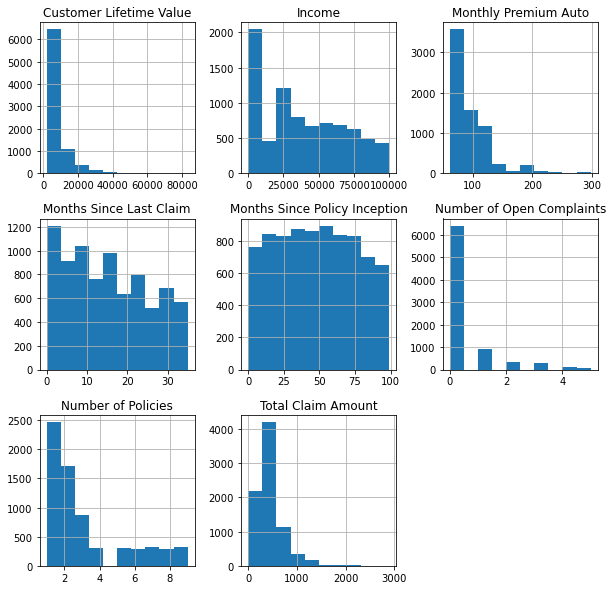

In [21]:
CLV.hist(figsize = (10,10))

### Customer

The customer is the ID column, so I drop it from the model

In [22]:
CLV.drop('Customer', axis = 1, inplace = True)

### State

Since state is a categorical variable, I use a one-hot-vector

In [23]:
CLV['State'].value_counts()

Oregon        2475
California    2376
Arizona       1640
Nevada         842
Washington     766
Name: State, dtype: int64

In [24]:
dummies = pd.get_dummies(CLV['State'], prefix  = 'State')
CLV[dummies.columns] = dummies
CLV.drop('State', axis = 1, inplace = True)

### Response

Response is also categorical, but there are only 2 unique values, so I can make it a dummy variable

In [25]:
CLV['Response'].value_counts()

No     6926
Yes    1173
Name: Response, dtype: int64

In [26]:
CLV['Response'] = CLV['Response'].map({'No':1, 'Yes':0})

### Coverage

Coverage is an ordinal column: Premium is better than Extended, which is better than Basic. Therefore, I can assign numeric values

In [27]:
CLV['Coverage'].value_counts()

Basic       4216
Extended    2056
Premium      612
Name: Coverage, dtype: int64

I replace the missing values with the most common value

In [28]:
CLV['Coverage'].replace(np.NaN, 'Basic', inplace = True)

In [29]:
CLV['Coverage'] = CLV['Coverage'].map({'Basic':0,'Extended':1, 'Premium':2})

### Education

Education is also ordinal, so I assign numeric values from 0 (least education) to 4 (most education)

In [30]:
CLV['Education'].value_counts()

Bachelor                2430
College                 2369
High School or Below    2339
Master                   648
Doctor                   313
Name: Education, dtype: int64

In [31]:
CLV['Education'] = CLV['Education'].map({'High School or Below': 0, 'College':1, 'Bachelor':2, 'Master':3,'Doctor':4})

### Effective to Date

Effective to Date is a date column, which means, in order to extract value, I need to convert it to a numeric value. I chose to do this by assuming that the date of the data set was January 1, 2011 and calculated the number of days until the coverage expired.

In [32]:
CLV['Effective To Date'].tail() 

8094     1/1/2011
8095     2/7/2011
8096    1/29/2011
8097    1/31/2011
8098    1/25/2011
Name: Effective To Date, dtype: object

In [33]:
CLV['DaysUntilExpired'] = (pd.to_datetime(CLV['Effective To Date'])  - pd.to_datetime('1/1/2011')).dt.days

This column also had null values, so I imputed using the average

In [34]:
avg = CLV['DaysUntilExpired'].mean()
CLV['DaysUntilExpired'].replace(np.NaN, avg, inplace = True)
CLV.drop('Effective To Date', axis = 1, inplace = True)

In [35]:
CLV['DaysUntilExpired'] = CLV['DaysUntilExpired'].astype(int)

### Employment Status

Employment status is categorical, so I use one-hot-vector

In [36]:
CLV['EmploymentStatus'].value_counts()

Employed         5079
Unemployed       2041
Medical Leave     376
Disabled          357
Retired           246
Name: EmploymentStatus, dtype: int64

In [37]:
dummies = pd.get_dummies(CLV['EmploymentStatus'], prefix = 'EmpStatus')
CLV[dummies.columns] = dummies
CLV.drop('EmploymentStatus', axis = 1, inplace = True)

### Gender

Gender is categorical with 2 unique values, so use a dummy variable

In [38]:
CLV['Gender'].value_counts()

F    4164
M    3935
Name: Gender, dtype: int64

In [39]:
CLV['Gender'] = CLV['Gender'].map({'F':1,'M':0})

### Income

This column needs no processing

### Location Code

The column is categorical, so I use a one-hot-vector

In [40]:
CLV['Location Code'].value_counts()

Suburban    4338
Rural       1357
Urban       1189
Name: Location Code, dtype: int64

Here, I replace the missing values with the most common value

In [41]:
CLV['Location Code'].replace(np.NaN, 'Suburban', inplace = True)

In [42]:
dummies = pd.get_dummies(CLV['Location Code'], prefix = 'Location')
CLV[dummies.columns] = dummies
CLV.drop('Location Code', axis = 1, inplace = True)

### Marital Status

Marital Status is categorical, so I use a one-hot-vector

In [43]:
CLV['Marital Status'].value_counts()

Married     4042
Single      1802
Divorced    1040
Name: Marital Status, dtype: int64

Replace the NA's with the most common value

In [44]:
CLV['Marital Status'].replace(np.NaN, 'Married', inplace = True)

In [45]:
dummies = pd.get_dummies(CLV['Marital Status'], prefix = 'Marital')
CLV[dummies.columns] = dummies
CLV.drop('Marital Status', axis = 1, inplace = True)

### Monthly Premium Auto

In [46]:
avg = CLV['Monthly Premium Auto'].mean()

Replace the missing values with the mean

In [47]:
CLV['Monthly Premium Auto'].replace(np.NaN, avg, inplace = True)

### Number of Policies

<AxesSubplot:>

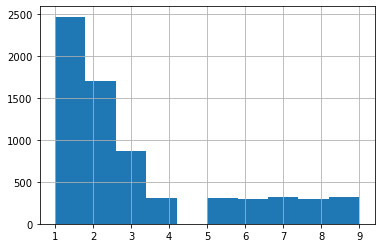

In [48]:
CLV['Number of Policies'].hist()

In [49]:
CLV['Number of Policies'].mean()

2.97472399767577

Replace the missing values with the mean

In [50]:
CLV['Number of Policies'].replace(np.NaN, CLV['Number of Policies'].mean(), inplace = True )

### Policy Type

This column is categorical, so I use a one-hot vector

In [51]:
CLV['Policy Type'].value_counts()

Personal Auto     5124
Corporate Auto    1438
Special Auto       322
Name: Policy Type, dtype: int64

Replace the NA's with the most common

In [52]:
CLV['Policy Type'].replace(np.NaN, 'Personal Auto', inplace = True)

In [53]:
dummies = pd.get_dummies(CLV['Policy Type'], prefix = 'Policy Type')
CLV[dummies.columns] = dummies
CLV.drop('Policy Type', axis = 1, inplace = True)

### Policy

This column is strange because there is an order within the categorical variables, and technically, the first part (personal, corporate,or special) is a repeat of the previous column.

I can handle this in 2 ways: 
1. Delete the first part and just consider the policy level
2. Pretend as if policy and policy type are two different, unrelated columns

I decided to use the first way, and just consider the policy level for this column. This means I had to consider policy, corporate, and special as individual columns and use the level as the ordinal value 

Handling missing values: I thought about using the previous column to help impute the missing values on this one and vice versa, but that seems like it is "cheating" in a way

In [54]:
CLV['Policy'].value_counts()

Personal L3     2648
Personal L2     1539
Personal L1      954
Corporate L3     736
Corporate L2     439
Corporate L1     261
Special L2       134
Special L3       122
Special L1        51
Name: Policy, dtype: int64

In [55]:
#dummies = pd.get_dummies(CLV['Policy'], prefix = 'Policy')
#CLV[dummies.columns] = dummies
#CLV.drop('Policy', axis = 1, inplace = True)

Get rid of the policy type

In [56]:
CLV.loc[CLV['Policy'].isin(['Personal L3', 'Corporate L3', 'Special L3']),'Policy'] = 3
CLV.loc[CLV['Policy'].isin(['Personal L2', 'Corporate L2', 'Special L2']),'Policy'] = 2
CLV.loc[CLV['Policy'].isin(['Personal L1', 'Corporate L1', 'Special L1']),'Policy'] = 1

In [57]:
CLV['Policy'].value_counts()

3    3506
2    2112
1    1266
Name: Policy, dtype: int64

Impute the missing values using the most common value

In [58]:
CLV['Policy'].replace(np.NaN, 3, inplace = True)

Create 3 separate columns for each policy type, then assign ordinal values based on the level of policy

In [59]:
CLV['Policy_Level_Corporate'] = CLV['Policy'].mask(CLV['Policy Type_Corporate Auto'] == 0, other = 0)
CLV['Policy_Level_Personal'] = CLV['Policy'].mask(CLV['Policy Type_Personal Auto'] == 0, other = 0)
CLV['Policy_Level_Special'] = CLV['Policy'].mask(CLV['Policy Type_Special Auto'] == 0, other = 0)

In [60]:
CLV.drop(['Policy Type_Corporate Auto','Policy Type_Personal Auto','Policy Type_Special Auto'],axis = 1, inplace = True)

### Renew Offer Type

This was also a weird column. Since there is not enough information on what the offer means, this could be ordinal or categorical. I chose to treat it as categorical, because there is no indication that Offer1 is better or worse than Offer2. 

In [61]:
CLV['Renew Offer Type'].value_counts()

Offer1    3324
Offer2    2591
Offer3    1262
Offer4     922
Name: Renew Offer Type, dtype: int64

In [62]:
dummies = pd.get_dummies(CLV['Renew Offer Type'], prefix = 'RenewOfferType')
CLV[dummies.columns] = dummies
CLV.drop('Renew Offer Type', axis = 1, inplace = True)

### Sales Channel

This column is categorical, so I use a one-hot-vector

In [63]:
CLV['Sales Channel'].value_counts()

Agent          3087
Branch         2255
Call Center    1567
Web            1190
Name: Sales Channel, dtype: int64

In [64]:
dummies = pd.get_dummies(CLV['Sales Channel'], prefix = 'SalesChannel')
CLV[dummies.columns] = dummies
CLV.drop('Sales Channel', axis = 1, inplace = True)

### Total Claim Amount

No processing needed

<AxesSubplot:>

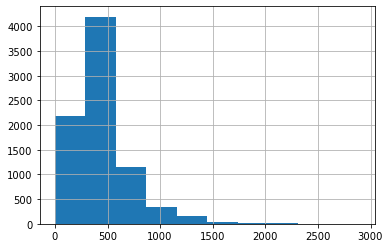

In [65]:
CLV['Total Claim Amount'].hist()

### Vehicle Class

This is categorical, so I use a one-hot-vector approach

In [66]:
CLV['Vehicle Class'].value_counts()

Four-Door Car    3503
Two-Door Car     1404
SUV              1346
Sports Car        376
Luxury SUV        134
Luxury Car        121
Name: Vehicle Class, dtype: int64

Replace the missing values with the most common one

In [67]:
CLV['Vehicle Class'].replace(np.NaN, 'Four-Door Car', inplace = True)

In [68]:
dummies = pd.get_dummies(CLV['Vehicle Class'], prefix = 'VehicleClass')
CLV[dummies.columns] = dummies
CLV.drop('Vehicle Class', axis = 1, inplace = True)

### Vehicle Size

This is ordinal, since large is bigger than medium which is bigger than small, so I map it from 0 (small) to 2 (large)

In [69]:
CLV['Vehicle Size'].value_counts()

Medsize    5671
Small      1585
Large       843
Name: Vehicle Size, dtype: int64

In [70]:
CLV['Vehicle Size'] = CLV['Vehicle Size'].map({'Small':0, 'Medsize':1, 'Large':2})

# Prepare the dataset for modeling

In [71]:
CLV.isnull().sum()

Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Gender                           0
Income                           0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy                           0
Total Claim Amount               0
Vehicle Size                     0
State_Arizona                    0
State_California                 0
State_Nevada                     0
State_Oregon                     0
State_Washington                 0
DaysUntilExpired                 0
EmpStatus_Disabled               0
EmpStatus_Employed               0
EmpStatus_Medical Leave          0
EmpStatus_Retired                0
EmpStatus_Unemployed             0
Location_Rural                   0
Location_Suburban                0
Location_Urban                   0
Marital_Divorced    

In [72]:
CLV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8099 entries, 0 to 8098
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer Lifetime Value        8099 non-null   float64
 1   Response                       8099 non-null   int64  
 2   Coverage                       8099 non-null   int64  
 3   Education                      8099 non-null   int64  
 4   Gender                         8099 non-null   int64  
 5   Income                         8099 non-null   int64  
 6   Monthly Premium Auto           8099 non-null   float64
 7   Months Since Last Claim        8099 non-null   int64  
 8   Months Since Policy Inception  8099 non-null   int64  
 9   Number of Open Complaints      8099 non-null   int64  
 10  Number of Policies             8099 non-null   float64
 11  Policy                         8099 non-null   int64  
 12  Total Claim Amount             8099 non-null   f

Split the data set

In [73]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = CLV.drop('Customer Lifetime Value', axis = 1)
y = CLV['Customer Lifetime Value']

X_train_org, X_test_org, y_train, y_test = train_test_split(X,y, random_state = 0)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

# Regression Models

In [74]:
from sklearn.model_selection import GridSearchCV

### KNN

In [78]:
from sklearn.neighbors import KNeighborsRegressor
param_grid_knn = {'n_neighbors': np.arange(3,40)}

In [79]:
%%time
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, return_train_score=True, n_jobs = -1)
grid_search_knn.fit(X_train, y_train)

CPU times: user 468 ms, sys: 311 ms, total: 779 ms
Wall time: 36.5 s


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])},
             return_train_score=True)

In [80]:
print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)

{'n_neighbors': 17}
0.0714131982781119


In [81]:
results_knn = pd.DataFrame(grid_search_knn.cv_results_)

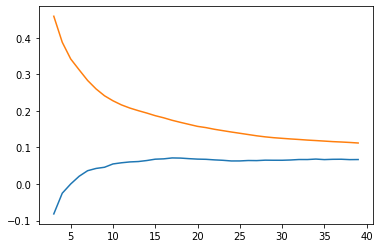

In [82]:
plt.plot(param_grid_knn['n_neighbors'], results_knn['mean_test_score'], label = 'test')
plt.plot(param_grid_knn['n_neighbors'], results_knn['mean_train_score'], label= 'train')

The best result for grid search for knn is 17 neighbors with a score of 0.0716. 

### Linear Regression

In [83]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()
lreg.fit(X_train, y_train)
print(lreg.score(X_train, y_train))
print(lreg.score(X_test, y_test))

0.15536738737114275
0.1379673900212679


Linear regression gives a train score of 0.1539 and a test score of 0.1381

### Ridge

In [84]:
from sklearn.linear_model import Ridge
param_grid_ridge = {'alpha': [.0001,.001,.01,.1,1,10,100,1000],'random_state': [0]}
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, return_train_score=True, n_jobs = -1)
grid_search_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'random_state': [0]},
             return_train_score=True)

In [85]:
results_ridge = pd.DataFrame(grid_search_ridge.cv_results_)
print(grid_search_ridge.best_params_)
print(grid_search_ridge.best_score_)

{'alpha': 10, 'random_state': 0}
0.143006755345092


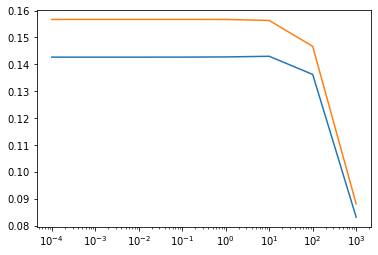

In [86]:
plt.plot(param_grid_ridge['alpha'],results_ridge['mean_test_score'], label = 'test')
plt.plot(param_grid_ridge['alpha'],results_ridge['mean_train_score'], label= 'train')
plt.xscale('log')

The best result for ridge regression is alpha = 10, with an average test score of 0.1430

### Lasso

In [87]:
from sklearn.linear_model import Lasso
param_grid_lasso = {'alpha': [.0001,.001,.01,.1,1,10,100,1000],'random_state':[0]}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv = 5,return_train_score = True, n_jobs = -1)
grid_search_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'random_state': [0]},
             return_train_score=True)

In [88]:
results_lasso = pd.DataFrame(grid_search_ridge.cv_results_)
print(grid_search_lasso.best_params_)
print(grid_search_lasso.best_score_)

{'alpha': 10, 'random_state': 0}
0.14442721243746687


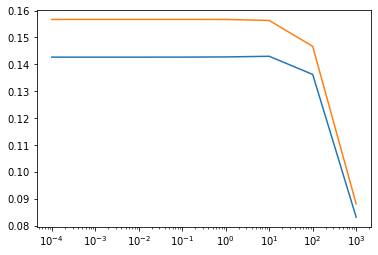

In [89]:
plt.plot(param_grid_lasso['alpha'],results_lasso['mean_test_score'], label = 'test')
plt.plot(param_grid_lasso['alpha'],results_lasso['mean_train_score'], label= 'train')
plt.xscale('log')

The best result for lasso regression is alpha = 10, with a test score of 0.1444

### Polynomial Regression

In [90]:
%%time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
train_score = []
test_score = []
for n in [2,3]:
    poly = PolynomialFeatures(degree = n)
    x_poly = poly.fit_transform(X_train)
    x_test_poly = poly.transform(X_test)
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly, y_train)
    train_score.append(poly_reg.score(x_poly, y_train))
    test_score.append(poly_reg.score(x_test_poly, y_test))

CPU times: user 5min 37s, sys: 25.4 s, total: 6min 3s
Wall time: 1min


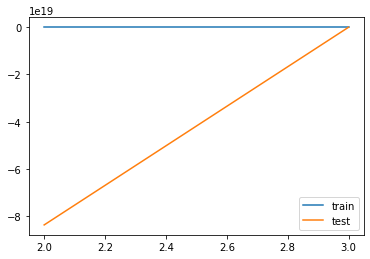

In [91]:
plt.plot([2,3],train_score,label='train')
plt.plot([2,3],test_score,label = 'test')
plt.legend()

The best result for polynomial regression is degree 3, with a test score of -27

### linearSVM

In [92]:
from sklearn.svm import LinearSVR
param_grid_linSVR = {'C': [0.001, 0.01, 0.1, 1, 10, 100,1000, 10000], 'max_iter': [5000], 'random_state': [0]}
grid_search_linSVR = GridSearchCV(LinearSVR(),param_grid_linSVR,cv = 5, return_train_score = True, n_jobs = -1)
grid_search_linSVR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'max_iter': [5000], 'random_state': [0]},
             return_train_score=True)

In [93]:
results_lasso = pd.DataFrame(grid_search_linSVR.cv_results_)
print(grid_search_linSVR.best_params_)
print(grid_search_linSVR.best_score_)


{'C': 10000, 'max_iter': 5000, 'random_state': 0}
0.06046315295672362


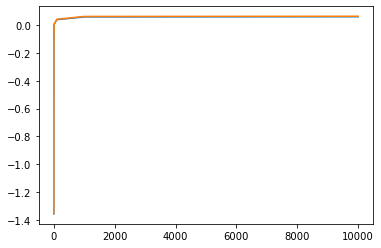

In [94]:
plt.plot(results_lasso['param_C'], results_lasso['mean_test_score'])
plt.plot(results_lasso['param_C'], results_lasso['mean_train_score'])

The best score for linear SVM was at C = 1000, with a score of 0.0591.

### SVM with rbf kernel

In [95]:
%%time
from sklearn.svm import SVR
param_grid_SVRrbf = {'kernel':['rbf'],'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_SVRrbf = GridSearchCV(SVR(), param_grid_SVRrbf, 
                                 cv=5, return_train_score=True, n_jobs = -1)
grid_search_SVRrbf.fit(X_train,y_train)

CPU times: user 5.55 s, sys: 181 ms, total: 5.73 s
Wall time: 5min 24s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf']},
             return_train_score=True)

In [96]:
results_SVRrbf = pd.DataFrame(grid_search_SVRrbf.cv_results_)
print(grid_search_SVRrbf.best_params_)
print(grid_search_SVRrbf.best_score_)

{'C': 10000, 'gamma': 0.1, 'kernel': 'rbf'}
0.09404783742564007


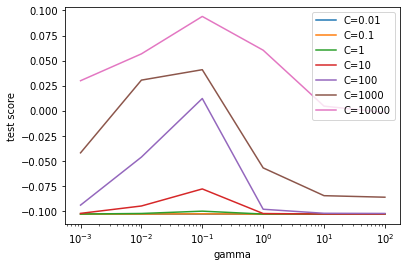

In [97]:
for c in param_grid_SVRrbf['C']:
    plt.plot(param_grid_SVRrbf['gamma'],results_SVRrbf['mean_test_score'][results_SVRrbf['param_C'] == c], label= 'C={}'.format(c))
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('test score')
plt.legend()

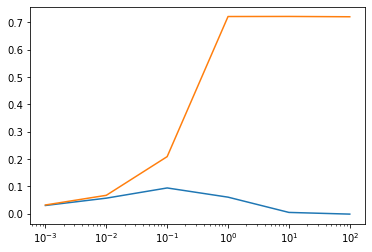

In [98]:
plt.plot(param_grid_SVRrbf['gamma'],
         results_SVRrbf['mean_test_score'][results_SVRrbf['param_C'] == 10000])
plt.plot(param_grid_SVRrbf['gamma'],
         results_SVRrbf['mean_train_score'][results_SVRrbf['param_C'] == 10000])
plt.xscale('log')

The best score for SVR with an rbf kernel is 0.0940, with C = 10000 and gamma = 0.1.

### SVM with poly kernel

In [99]:
%%time
param_grid_SVRpoly = {'kernel':['poly'],'degree': np.arange(10,25)}
grid_search_SVRpoly = GridSearchCV(SVR(), param_grid_SVRpoly, 
                                 cv=5, return_train_score=True, n_jobs = -1)
grid_search_SVRpoly.fit(X_train,y_train)

CPU times: user 2.69 s, sys: 94.5 ms, total: 2.79 s
Wall time: 57.6 s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'degree': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
                         'kernel': ['poly']},
             return_train_score=True)

In [100]:
results_SVRpoly = pd.DataFrame(grid_search_SVRpoly.cv_results_)
print(grid_search_SVRpoly.best_params_)
print(grid_search_SVRpoly.best_score_)

{'degree': 19, 'kernel': 'poly'}
-0.028339888979732962


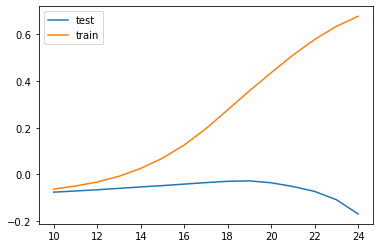

In [101]:
plt.plot(param_grid_SVRpoly['degree'],results_SVRpoly['mean_test_score'], label = 'test')
plt.plot(param_grid_SVRpoly['degree'],results_SVRpoly['mean_train_score'], label= 'train')
plt.legend()

The best score is -0.0283 with a degree of 19. 

### SVM with linear kernel

In [102]:
%%time
from sklearn.svm import SVR
param_grid_SVRlin = {'kernel':['linear'],'C': [.001,.1, 1, 10, 100, 1000, 10000]}
grid_search_SVRlin = GridSearchCV(SVR(), param_grid_SVRlin, 
                                 cv=5, return_train_score=True, n_jobs = -1)
grid_search_SVRlin.fit(X_train,y_train)

CPU times: user 2.05 s, sys: 94.2 ms, total: 2.14 s
Wall time: 36.7 s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10, 100, 1000, 10000],
                         'kernel': ['linear']},
             return_train_score=True)

In [103]:
results_SVRlin = pd.DataFrame(grid_search_SVRlin.cv_results_)
print(grid_search_SVRlin.best_params_)
print(grid_search_SVRlin.best_score_)

{'C': 1000, 'kernel': 'linear'}
0.060345192031645456


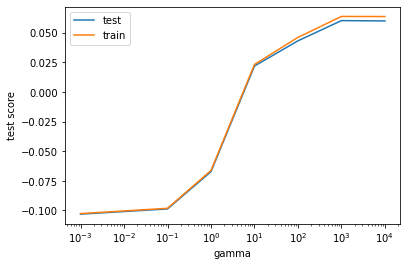

In [104]:
plt.plot(param_grid_SVRlin['C'],results_SVRlin['mean_test_score'], label = 'test')
plt.plot(param_grid_SVRlin['C'],results_SVRlin['mean_train_score'], label = 'train')

plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('test score')
plt.legend()

The best test score is at C = 1000, where the score is 0.0603.

### Decision Tree

In [105]:
from sklearn.tree import DecisionTreeRegressor
param_grid_tree = {'max_depth': np.arange(2,9), 
                   'min_samples_split': [2,10,50,100],'min_samples_leaf':[1,10,50,100],'min_impurity_decrease': [0,.001,.0001,.005]}
grid_search_tree = GridSearchCV(DecisionTreeRegressor(), param_grid_tree, cv = 5, return_train_score = True, n_jobs = -1)
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                         'min_impurity_decrease': [0, 0.001, 0.0001, 0.005],
                         'min_samples_leaf': [1, 10, 50, 100],
                         'min_samples_split': [2, 10, 50, 100]},
             return_train_score=True)

In [106]:
results_tree = pd.DataFrame(grid_search_tree.cv_results_)
grid_search_tree.best_params_

{'max_depth': 8,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 10,
 'min_samples_split': 100}

In [107]:
grid_search_tree.best_score_

0.5425409109721713

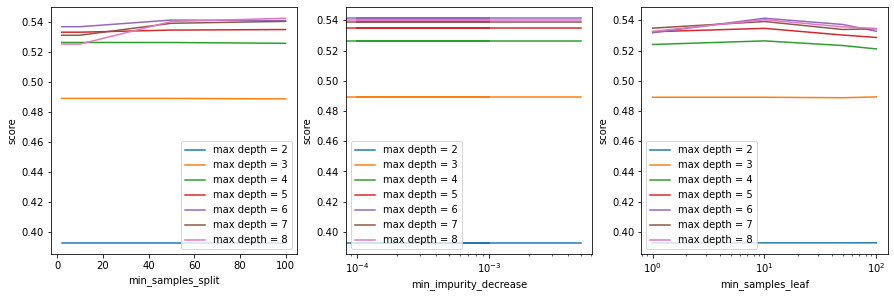

In [108]:
fig, axs = plt.subplots(1, 3, figsize = (15,10)) 

plt.subplot(2,3,1)
for depth in param_grid_tree['max_depth']:
    plt.plot(param_grid_tree['min_samples_split'],results_tree['mean_test_score'][(results_tree['param_max_depth'] == depth) &
            (results_tree['param_min_impurity_decrease'] == 0) & (results_tree['param_min_samples_leaf'] == 10)],
        label = 'max depth = {}'.format(depth))
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.legend()

plt.subplot(2,3,2)
for depth in param_grid_tree['max_depth']:
    plt.plot(param_grid_tree['min_impurity_decrease'],results_tree['mean_test_score'][(results_tree['param_max_depth'] == depth) &
            (results_tree['param_min_samples_split'] == 50) & (results_tree['param_min_samples_leaf'] == 10)],
        label = 'max depth = {}'.format(depth))
plt.xlabel('min_impurity_decrease')
plt.ylabel('score')
plt.xscale('log')
plt.legend()

plt.subplot(2,3,3)
for depth in param_grid_tree['max_depth']:
    plt.plot(param_grid_tree['min_samples_leaf'],results_tree['mean_test_score'][(results_tree['param_max_depth'] == depth) &
            (results_tree['param_min_samples_split'] == 50) & (results_tree['param_min_impurity_decrease'] == 0)],
        label = 'max depth = {}'.format(depth))
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.xscale('log')
plt.legend()

The test score mostly doesn't change when min_samples_split, min_impurity_decrease, and min_samples_leaf change, so the most important variable is max depth

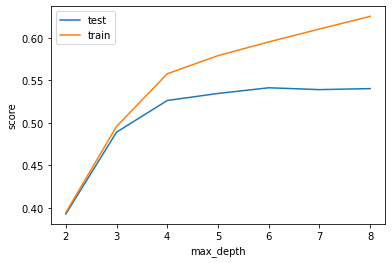

In [109]:
plt.plot(param_grid_tree['max_depth'],results_tree['mean_test_score'][(results_tree['param_min_samples_split'] == 50) &
            (results_tree['param_min_impurity_decrease'] == 0) & (results_tree['param_min_samples_leaf'] == 10)],
        label = 'test')
plt.plot(param_grid_tree['max_depth'],results_tree['mean_train_score'][(results_tree['param_min_samples_split'] == 50) &
            (results_tree['param_min_impurity_decrease'] == 0) & (results_tree['param_min_samples_leaf'] == 10)],
        label = 'train')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend()

The grid search shows a best score at a max depth of 6, with a min impurity decrease of 0, the min samples in a leaf of 10, and the min samples to split as 50. This gives a score of 0.5420. 

# Pick the best model

The decision tree model gave the best score, so that was the model that I used

In [114]:
tree = DecisionTreeRegressor(**grid_search_tree.best_params_)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_impurity_decrease=0.001,
                      min_samples_leaf=10, min_samples_split=100)

In [115]:
print(tree.score(X_train, y_train))
print(tree.score(X_test,y_test))

0.610294191813016
0.5434372211843381


Predict the values for the test set

In [116]:
y_predict_test = pd.DataFrame(tree.predict(X_test))
y_predict_test

,0
0,6252.516816
1,2579.835594
2,8626.950426
3,6673.226116
4,6673.226116
...,...
2020,5104.223903
2021,15046.009749
2022,13735.948129
2023,3473.549480


In [117]:
y_test

2569    21205.377850
5683     2435.147986
1564     8157.933629
5983     6883.665071
5547     6646.749298
            ...     
1421     4834.710493
2402    10003.247290
4927     8802.188243
5881     3049.837544
3519     6753.428413
Name: Customer Lifetime Value, Length: 2025, dtype: float64

# <font color='red'> Project 2

### Project Description:
- Use the same datasets as Project 1.
- Preprocess data: Explore data and apply data scaling.You can use the same preprocessing steps as it was used in Project 1. 
- Apply recommended changes if there is any. 

### Regression Task:
- Apply any two models with bagging and any two models with pasting. 
- Apply any two models with AdaBoost boosting. 
- Apply gradient boosting. 
- Apply PCA on data and then apply all the models in project 1 again on the post PCA data. Compare your results with results in project 1. You don't need to apply all the models twice. Just copy the result from project 1, prepare a similar table for all the models after PCA and compare. Does PCA help in getting better results? 
- Apply deep learning models (MLP) covered in class. 


### Deliverables:
- Use markdown to provide inline comments for this project. 
- Use markdown to create final report for this project. 
- Your outputs should be clearly executed in the notebook i.e. we should not need to rerun the code to obtain the outputs. 
- Visualization encouraged. 
- If you are submitting two different files, then please only one group member submit both the files. If you submit two files separately from different accounts, it will be submitted as two different attempts.
- If you are submitting two different files, then please follow below naming convention:
    - ``Project2_Regression_GroupXX_Lastname1_Lastname2.ipynb``
    - ``Project2_Classification_GroupXX_Lastname1_Lastname2.ipynb``
  
  then zip these two files and the csv files of the two datasets into one file and submit. 
- If you are submitting a single file, then please follow below naming convention:
    - ``Project2_Both_GroupXX_Lastname1_Lastname2.ipynb``
    
    then zip this file and the csv files of the two datasets into one file and submit. 

In [118]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from  sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

## Bagging for Decision Tree Regressor

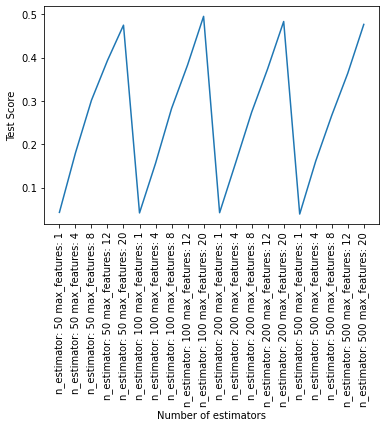

In [119]:
n_estimators = [50,100,200,500]
max_features = [1,4,8,12,20]
params=[]
scores = []

for estimator in n_estimators:
    for features in max_features:
        reg = BaggingRegressor(DecisionTreeRegressor(), \
                                max_samples=0.5, \
                                max_features=features, \
                                n_estimators=estimator, \
                               bootstrap=True, random_state=0, oob_score=True)
        reg.fit(X_train, y_train)
        score = reg.score(X_test, y_test)
        params.append("n_estimator: "+str(estimator)+" max_features: "+str(features))
        scores.append(score)
    
plt.plot(params, scores)
plt.xlabel("Number of estimators")
plt.xticks(rotation=90)
plt.ylabel("Test Score")
plt.show()

In [120]:
tuned_parameters = {"n_estimators": [50,100,200,500],
              "max_features":[1,4,8,12,20],
              "max_samples": [0.5,0.1],
            }
DecisionTree_reg = DecisionTreeRegressor()

DecisionTree_grid = GridSearchCV(BaggingRegressor(DecisionTree_reg,bootstrap=True, oob_score=True, random_state=0),tuned_parameters)
DecisionTree_grid_model= DecisionTree_grid.fit(X_train, y_train)

print("DecisionTree grid model Best params: ")
print(DecisionTree_grid_model.best_params_)

print('Train Score: ',DecisionTree_grid_model.score(X_train, y_train))
print('Test Score: ',DecisionTree_grid_model.score(X_test, y_test))
y_pred = DecisionTree_grid_model.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))

DecisionTree grid model Best params: 
{'max_features': 20, 'max_samples': 0.5, 'n_estimators': 100}
Train Score:  0.8149310075682036
Test Score:  0.4951260929705683
MSE:  23524550.918366067


## Bagging for Ridge Regression

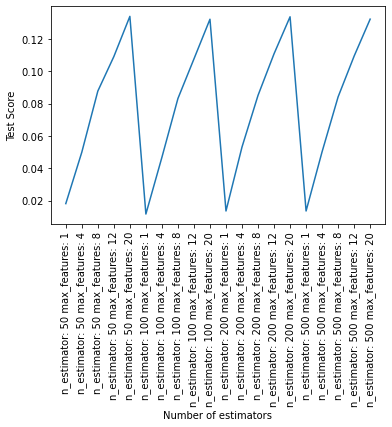

In [121]:
n_estimators = [50,100,200,500]
max_features = [1,4,8,12,20]
params=[]
scores = []

for estimator in n_estimators:
    for features in max_features:
        reg = BaggingRegressor(Ridge(max_iter=1000,alpha=1,tol=0.1,random_state=0), \
                                max_samples=0.5, \
                                max_features=features, \
                                n_estimators=estimator, \
                               bootstrap=True, random_state=0, oob_score=True)
        reg.fit(X_train, y_train)
        score = reg.score(X_test, y_test)
        params.append("n_estimator: "+str(estimator)+" max_features: "+str(features))
        scores.append(score)
    
plt.plot(params, scores)
plt.xlabel("Number of estimators")
plt.xticks(rotation=90)
plt.ylabel("Test Score")
plt.show()

In [122]:
tuned_parameters = {"n_estimators": [50,100,200,500],
              "max_features":[1,4,8,12,20],
              "max_samples": [0.5,0.1],
            }
Ridge_reg = Ridge(max_iter=1000,alpha=1,tol=0.1,random_state=0)

Ridge_reg_grid = GridSearchCV(BaggingRegressor(Ridge_reg,bootstrap=True, oob_score=True, random_state=0),tuned_parameters)
Ridge_reg_grid_model= Ridge_reg_grid.fit(X_train, y_train)

print("Ridge grid model Best params: ")
print(Ridge_reg_grid_model.best_params_)

print('Train Score: ',Ridge_reg_grid_model.score(X_train, y_train))
print('Test Score: ',Ridge_reg_grid_model.score(X_test, y_test))
y_pred = Ridge_reg_grid_model.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))

Ridge grid model Best params: 
{'max_features': 20, 'max_samples': 0.5, 'n_estimators': 200}
Train Score:  0.14172976521783753
Test Score:  0.13358998837415004
MSE:  40370290.781310424


## Pasting for Decision Tree Regressor

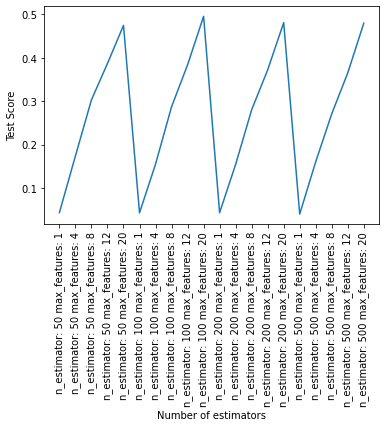

In [123]:
n_estimators = [50,100,200,500]
max_features = [1,4,8,12,20]
params=[]
scores = []

for estimator in n_estimators:
    for features in max_features:
        reg = BaggingRegressor(DecisionTreeRegressor(), \
                                max_samples=0.5, \
                                max_features=features, \
                                n_estimators=estimator, \
                               bootstrap=False, random_state=0)
        reg.fit(X_train, y_train)
        score = reg.score(X_test, y_test)
        params.append("n_estimator: "+str(estimator)+" max_features: "+str(features))
        scores.append(score)
    
plt.plot(params, scores)
plt.xlabel("Number of estimators")
plt.xticks(rotation=90)
plt.ylabel("Test Score")
plt.show()

In [124]:
tuned_parameters = {"n_estimators": [50,100,200,500],
              "max_features":[1,4,8,12,20],
              "max_samples": [0.5,0.1],
            }
DecisionTree_reg = DecisionTreeRegressor()

DecisionTree_grid = GridSearchCV(BaggingRegressor(DecisionTree_reg,bootstrap=False, random_state=0),tuned_parameters)
DecisionTree_grid_model= DecisionTree_grid.fit(X_train, y_train)

print("DecisionTree grid model Best params: ")
print(DecisionTree_grid_model.best_params_)

print('Train Score: ',DecisionTree_grid_model.score(X_train, y_train))
print('Test Score: ',DecisionTree_grid_model.score(X_test, y_test))
y_pred = DecisionTree_grid_model.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))

DecisionTree grid model Best params: 
{'max_features': 20, 'max_samples': 0.5, 'n_estimators': 100}
Train Score:  0.8715990592261551
Test Score:  0.4955308841639998
MSE:  23505689.711818054


## Pasting for Ridge Regression

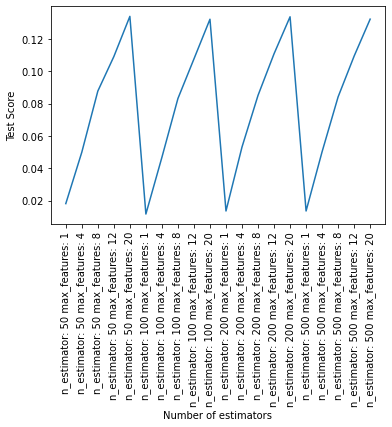

In [125]:
n_estimators = [50,100,200,500]
max_features = [1,4,8,12,20]
params=[]
scores = []

for estimator in n_estimators:
    for features in max_features:
        reg = BaggingRegressor(Ridge(max_iter=1000,alpha=1,tol=0.1,random_state=0), \
                                max_samples=0.5, \
                                max_features=features, \
                                n_estimators=estimator, \
                                random_state=0)
        reg.fit(X_train, y_train)
        score = reg.score(X_test, y_test)
        params.append("n_estimator: "+str(estimator)+" max_features: "+str(features))
        scores.append(score)
    
plt.plot(params, scores)
plt.xlabel("Number of estimators")
plt.xticks(rotation=90)
plt.ylabel("Test Score")
plt.show()

In [126]:
tuned_parameters = {"n_estimators": [50,100,200,500],
              "max_features":[1,4,8,12,20],
              "max_samples": [0.5,0.1],
            }
Ridge_reg = Ridge(max_iter=1000,alpha=1,tol=0.1,random_state=0)

Ridge_reg_grid = GridSearchCV(BaggingRegressor(Ridge_reg,bootstrap=False, random_state=0),tuned_parameters)
Ridge_reg_grid_model= Ridge_reg_grid.fit(X_train, y_train)

print("Ridge grid model Best params: ")
print(Ridge_reg_grid_model.best_params_)

print('Train Score: ',Ridge_reg_grid_model.score(X_train, y_train))
print('Test Score: ',Ridge_reg_grid_model.score(X_test, y_test))
y_pred = Ridge_reg_grid_model.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))

Ridge grid model Best params: 
{'max_features': 20, 'max_samples': 0.5, 'n_estimators': 200}
Train Score:  0.1417791570426027
Test Score:  0.13395155191918862
MSE:  40353443.76286273


## Adaboosting for Decision Tree regressor

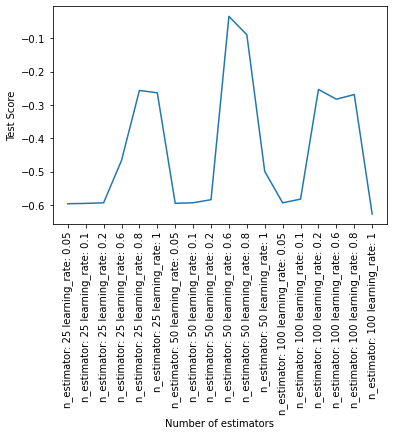

In [127]:
n_estimators = [25,50,100]
learning_rate = [0.05,0.1,0.2,0.6,0.8,1]
params=[]
scores = []

for estimator in n_estimators:
    for l_rate in learning_rate:
        reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3,random_state=0), \
                                 random_state=0, \
                                 n_estimators = estimator, \
                                 learning_rate = l_rate, \
                                 loss = "exponential")
        reg.fit(X, y)
        score = reg.score(X_test, y_test)
        params.append("n_estimator: "+str(estimator)+" learning_rate: "+str(l_rate))
        scores.append(score)
    
plt.plot(params, scores)
plt.xlabel("Number of estimators")
plt.xticks(rotation=90)
plt.ylabel("Test Score")
plt.show()

In [128]:
tuned_parameters = {"n_estimators": [50,100,200,500],
                    "learning_rate":[0.4,0.5,0.6,0.7,0.8,0.9]
                    }
dt = DecisionTreeRegressor(random_state=0, max_depth = 3)
dt_ada_grid = GridSearchCV(AdaBoostRegressor(dt, random_state=0),tuned_parameters)
dt_ada_grid_model = dt_ada_grid.fit(X_train,y_train)

y_pred = dt_ada_grid_model.predict(X_test)

print("Ada Boost model Best params: ")
print(dt_ada_grid_model.best_params_)

print('Train Score: ',dt_ada_grid_model.score(X_train, y_train))
print('Test Score: ',dt_ada_grid_model.score(X_test, y_test))
y_pred = dt_ada_grid_model.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))

Ada Boost model Best params: 
{'learning_rate': 0.4, 'n_estimators': 50}
Train Score:  0.023172645036680595
Test Score:  -0.02011280861033926
MSE:  47532057.75641797


## AdaBoosting for Ridge Regression

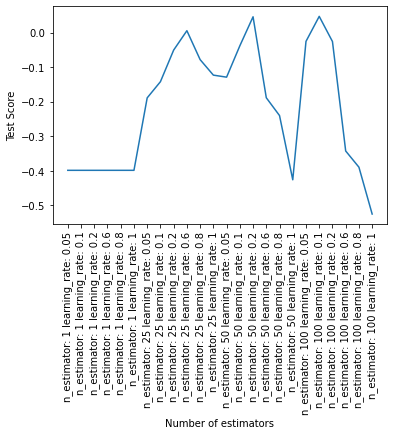

In [130]:
n_estimators = [1,25,50,100]
learning_rate = [0.05,0.1,0.2,0.6,0.8,1]
params=[]
scores = []

for estimator in n_estimators:
    for l_rate in learning_rate:
        reg = AdaBoostRegressor(Ridge(max_iter=1000,alpha=1,tol=0.1,random_state=0), \
                                 random_state=0, \
                                 n_estimators = estimator, \
                                 learning_rate = l_rate, \
                                 loss = "exponential")
        reg.fit(X, y)
        score = reg.score(X_test, y_test)
        params.append("n_estimator: "+str(estimator)+" learning_rate: "+str(l_rate))
        scores.append(score)
    
plt.plot(params, scores)
plt.xlabel("Number of estimators")
plt.xticks(rotation=90)
plt.ylabel("Test Score")
plt.show()

In [131]:
tuned_parameters = {"learning_rate":[0.05,0.1,0.2,0.6,0.8,1],
                    "n_estimators": [1,25,50,100],
                    "loss" : ["linear", "square", "exponential"]
                   }

ridge = Ridge(max_iter=1000,alpha=1,tol=0.1,random_state=0)

ridge_ada_grid = GridSearchCV(AdaBoostRegressor(ridge, random_state=0),tuned_parameters)
ridge_ada_grid_model =ridge_ada_grid.fit(X_train, y_train)

print("Ridge Adaboosting grid model Best params: ")
print(ridge_ada_grid_model.best_params_)

print('Train Score: ',ridge_ada_grid_model.score(X_train, y_train))
print('Test Score: ',ridge_ada_grid_model.score(X_test, y_test))
y_pred = ridge_ada_grid_model.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))

Ridge Adaboosting grid model Best params: 
{'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 1}
Train Score:  0.14633101008278127
Test Score:  0.11471548702682166
MSE:  41249746.347981475


## Gradient Boosting

In [132]:
tuned_parameters = {"max_depth": [3,5,6,7],
                    "n_estimators": range(10,100)}

grad_boost_grid = GridSearchCV(GradientBoostingRegressor(random_state=0),tuned_parameters)
grad_boost_grid_model = grad_boost_grid.fit(X_train,y_train)

print("Gradient boosting grid model Best params: ")
print(grad_boost_grid_model.best_params_)

print('Train Score: ',grad_boost_grid_model.score(X_train, y_train))
print('Test Score: ',grad_boost_grid_model.score(X_test, y_test))
y_pred = grad_boost_grid_model.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))

Gradient boosting grid model Best params: 
{'max_depth': 3, 'n_estimators': 67}
Train Score:  0.6284762154252164
Test Score:  0.573638181935481
MSE:  19866287.718690142


## Principle Component Analysis

In [79]:
from sklearn.decomposition import PCA
pca90 = PCA(.90,random_state=0)
pca90.fit(X_train)
pca90.n_components_

25

In [80]:
pca95 = PCA(.95,random_state=0)
pca95.fit(X_train)
pca95.n_components_

29

In [81]:
pca99 = PCA(.99,random_state=0)
pca99.fit(X_train)
pca99.n_components_

35

In [82]:
X_train_without_PCA= X_train
X_test_without_PCA= X_test
X_train_pca = pca95.transform(X_train)
X_test_pca = pca95.transform(X_test)

## 1) Linear Regression

In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn import linear_model
lreg = linear_model.LinearRegression()

lreg.fit(X_train_pca, y_train)
print('Train Score: ',lreg.score(X_train_pca, y_train))
print('Test Score: ',lreg.score(X_test_pca, y_test))
y_pred = lreg.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))

Train Score:  0.10076904791246932
Test Score:  0.07054456400275633
MSE:  43307886.23860228


## 2) KNN Regressor

Text(0, 0.5, 'Accuracy')

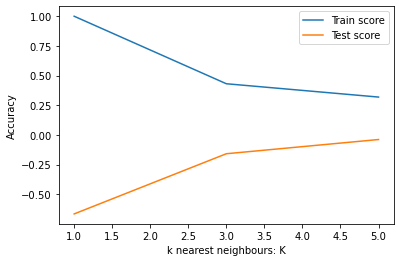

In [138]:
k_range = range(1,6,2)
train_score_knn = []
test_score_knn = []

for k in k_range:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train_pca, y_train)
    train_score_knn.append(neigh.score(X_train_pca, y_train))
    test_score_knn.append(neigh.score(X_test_pca, y_test))
    

plt.plot(k_range, train_score_knn, label = 'Train score')
plt.plot(k_range, test_score_knn, label = 'Test score')
plt.legend()
plt.xlabel('k nearest neighbours: K')
plt.ylabel('Accuracy')

In [139]:
x_range_1 = range(1,6,2)
tuned_parameters=dict(n_neighbors=x_range_1)

knn_reg = KNeighborsRegressor()
gri12=GridSearchCV(knn_reg,tuned_parameters,cv=3)
gri_model12=gri12.fit(X_train_pca,y_train)
print(gri_model12.best_params_)
y_pred12= gri_model12.score(X_test_pca,y_test)
print('Train Score: ',gri_model12.score(X_train_pca, y_train))
print('Test Score: ',gri_model12.score(X_test_pca, y_test))
y_pred = gri_model12.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))

{'n_neighbors': 5}
Train Score:  0.319192144248009
Test Score:  -0.03844227725341254
MSE:  48386117.57689396


## 3) Ridge Regression

Text(0.5, 0, '$\\alpha$')

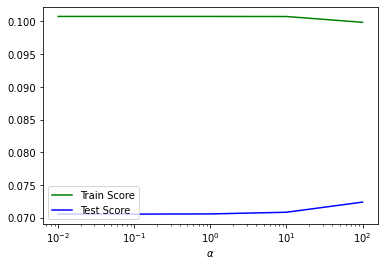

In [140]:
from  sklearn.linear_model import Ridge

x_range = [0.01, 0.1, 1, 10, 100]
train_score_list = []
test_score_list = []

for alpha in x_range: 
    ridge = Ridge(alpha,random_state=0)
    ridge.fit(X_train_pca,y_train)
    train_score_list.append(ridge.score(X_train_pca,y_train))
    test_score_list.append(ridge.score(X_test_pca, y_test))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_range, train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')

In [141]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
np.random.seed(0)
    
x_range = [0.01, 0.1, 1, 10, 100]
tuned_parameters = [{'alpha':x_range}]

ridge = Ridge(max_iter=1000,tol=0.1,random_state=0)
gri1=GridSearchCV(ridge,tuned_parameters,cv=5, return_train_score= True)
gri_model1=gri1.fit(X_train_pca,y_train)

print(gri1.best_params_)
y_pred1= gri1.score(X_test_pca,y_test)
print('Train Score: ',gri1.score(X_train_pca, y_train))
print('Test Score: ',gri1.score(X_test_pca, y_test))
y_pred = gri1.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))

{'alpha': 10}
Train Score:  0.100757859310586
Test Score:  0.07083037138023773
MSE:  43294569.071462534


## 4) Lasso Regression

Text(0.5, 0, '$\\alpha$')

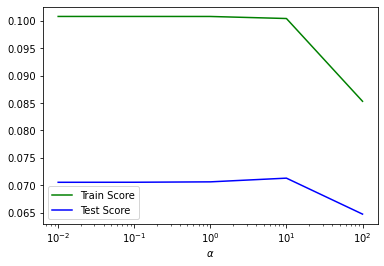

In [142]:
from sklearn.linear_model import Lasso
x_range = [0.01, 0.1, 1, 10, 100]
train_score_list = []
test_score_list = []

for alpha in x_range: 
    lasso = Lasso(alpha,random_state=0)
    lasso.fit(X_train_pca,y_train)
    train_score_list.append(lasso.score(X_train_pca,y_train))
    test_score_list.append(lasso.score(X_test_pca, y_test))
    
    
plt.plot(x_range, train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')

In [143]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
np.random.seed(0)
    
x_range = [0.01, 0.1, 1, 10, 100]
tuned_parameters = [{'alpha':x_range}]

lasso = Lasso(max_iter=1000,tol=0.1,random_state=0)
gri=GridSearchCV(lasso,tuned_parameters,cv=5, return_train_score= True)
gri_model=gri.fit(X_train_pca,y_train)

print(gri_model.best_params_)
y_pred= gri_model.score(X_test_pca,y_test)

print('Train Score: ',gri_model.score(X_train_pca, y_train))
print('Test Score: ',gri_model.score(X_test_pca, y_test))
y_pred = gri_model.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))

{'alpha': 10}
Train Score:  0.10039124375406738
Test Score:  0.07130076886506109
MSE:  43272650.94610584


## 5) Linear SVR

In [144]:
from sklearn import svm
from sklearn.svm import LinearSVR

tuning_parameters = [{'C': [0.01, 0.1 ,1, 10, 100], 'max_iter' : [10000]}]

lsvm_grid = GridSearchCV(svm.LinearSVR(), param_grid=tuning_parameters,cv=5,)
grid_lsvm=lsvm_grid.fit(X_train_pca,y_train) 

print('Best Paramters' ,grid_lsvm.best_params_)
print('train score: ', grid_lsvm.score(X_train_pca, y_train))
print('test score: ', grid_lsvm.score(X_test_pca, y_test))
y_pred = grid_lsvm.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))

Best Paramters {'C': 100, 'max_iter': 10000}
train score:  0.000593939893265838
test score:  -0.0474904237932019
MSE:  48807715.09070588


## 6) SVR (Kernel = 'linear')

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

tuning_parameters = {'C':[0.1, 1,10,100], 'kernel':['linear']}

svm_grid = GridSearchCV(svm.SVR(), param_grid=tuning_parameters,cv=3)
svm_model_linear=svm_grid.fit(X_train_pca,y_train) 

print('Best Paramters' ,svm_model_linear.best_params_)
print('train score: ', svm_model_linear.score(X_train_pca, y_train))
print('test score: ', svm_model_linear.score(X_test_pca, y_test))
y_pred = svm_model_linear.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))

Best Paramters {'C': 100, 'kernel': 'linear'}
train score:  0.007685166377711328
test score:  -0.039407807588762944
MSE:  48431106.36958246


## 7) SVR (Kernel = 'Poly')

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

tuning_parameters = {'C':[0.1, 1,10,100], 'kernel':['poly']}

svm_grid = GridSearchCV(svm.SVR(), param_grid=tuning_parameters,cv=3)
svm_model_poly=svm_grid.fit(X_train_pca,y_train) 
print(svm_model_poly.best_params_)

print('train score: ', svm_model_poly.score(X_train_pca, y_train))
print('test score: ', svm_model_poly.score(X_test_pca, y_test))
y_pred = svm_model_poly.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))


{'C': 100, 'kernel': 'poly'}
train score:  -0.014237647028483735
test score:  -0.04138657082961461
MSE:  48523306.65160673


## 8) SVR (Kernel = 'rbf')

In [147]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

tuning_parameters = {'C':[0.1, 1,10,100], 'kernel':['rbf']}

svm_grid = GridSearchCV(svm.SVR(), param_grid=tuning_parameters,cv=3)
svm_model_rbf=svm_grid.fit(X_train_pca,y_train) 
print(svm_model_rbf.best_params_)

print('train score: ', svm_model_rbf.score(X_train_pca, y_train))
print('test score: ', svm_model_rbf.score(X_test_pca, y_test))
y_pred = svm_model_rbf.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))


{'C': 100, 'kernel': 'rbf'}
train score:  0.010981052099239719
test score:  -0.023456753503002803
MSE:  47687868.54560793


## 9) Decision Tree Regressor

In [148]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(DecisionTreeRegressor(random_state= 0), parameters, n_jobs=4)
clf.fit(X=X_train_pca, y=y_train)
print (clf.best_score_, clf.best_params_) 


print('train score: ', clf.score(X_train_pca, y_train))
print('test score: ', clf.score(X_test_pca, y_test))
y_pred = clf.predict(X_test_pca)
print('MSE: ',mean_squared_error(y_test, y_pred))

0.07795454194703558 {'max_depth': 3}
train score:  0.11808922576326897
test score:  0.05463450759562749
MSE:  44049213.77970208


## Deep Learning Model

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.metrics import AUC
import tensorflow
from sklearn.model_selection import GridSearchCV

np.random.seed(0)
tensorflow.random.set_seed(0)

In [83]:
X_train1 = np.asarray(X_train_without_PCA) 
X_test1 = np.asarray(X_test_without_PCA) 
y_train1 = np.asarray(y_train) 
y_test1 = np.asarray(y_test) 

In [84]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.metrics import AUC

np.random.seed(0)
tensorflow.random.set_seed(0)

In [85]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [86]:
def create_model():
    #create model
    model = Sequential()
    model.add(Dense(12, input_dim=47, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [87]:
seed = 10
np.random.seed(10)

In [88]:
model = KerasRegressor(build_fn = create_model, verbose = 0)

param_grid = {'batch_size':[10,20,30,40] , 'epochs':[10, 50, 100]}
grid_search = GridSearchCV(estimator= model, param_grid = param_grid, cv = 5)

In [89]:
grid_search_result = grid_search.fit(X, y)

In [90]:
print('Best Paramters' ,grid_search_result.best_params_)

Best Paramters {'batch_size': 10, 'epochs': 100}


In [93]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(Dense(12, input_dim=47, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', 'mae'])

model.fit(X_train1, y_train1, epochs= 100, batch_size=10)

y_pred1 = model.predict(X_test1)
print(model.evaluate(X_train1,y_train1))
print(model.evaluate(X_test1,y_test1))
print(mean_squared_error(y_test1, y_pred1))

Epoch 1/100
608/608 [==============================] - 3s 4ms/step - loss: 110279880.0000 - mse: 110279888.0000 - mae: 7956.6113
Epoch 2/100
608/608 [==============================] - 2s 3ms/step - loss: 106462016.0000 - mse: 106462024.0000 - mae: 7713.0967
Epoch 3/100
608/608 [==============================] - 3s 5ms/step - loss: 99841432.0000 - mse: 99841432.0000 - mae: 7274.1279
Epoch 4/100
608/608 [==============================] - 2s 3ms/step - loss: 91660232.0000 - mse: 91660232.0000 - mae: 6690.5200
Epoch 5/100
608/608 [==============================] - 2s 3ms/step - loss: 82875936.0000 - mse: 82875936.0000 - mae: 6005.8628
Epoch 6/100
608/608 [==============================] - 2s 3ms/step - loss: 74270352.0000 - mse: 74270352.0000 - mae: 5307.5879
Epoch 7/100
608/608 [==============================] - 2s 4ms/step - loss: 66486184.0000 - mse: 66486184.0000 - mae: 4765.1968
Epoch 8/100
608/608 [==============================] - 2s 3ms/step - loss: 59924316.0000 - mse: 59924320.00

608/608 [==============================] - 1s 2ms/step - loss: 42981168.0000 - mse: 42981168.0000 - mae: 4178.4473
Epoch 62/100
608/608 [==============================] - 1s 2ms/step - loss: 42934068.0000 - mse: 42934064.0000 - mae: 4168.0581
Epoch 63/100
608/608 [==============================] - 1s 2ms/step - loss: 42884856.0000 - mse: 42884856.0000 - mae: 4163.4604
Epoch 64/100
608/608 [==============================] - 1s 2ms/step - loss: 42836752.0000 - mse: 42836752.0000 - mae: 4167.1733
Epoch 65/100
608/608 [==============================] - 1s 2ms/step - loss: 42788336.0000 - mse: 42788336.0000 - mae: 4162.4897
Epoch 66/100
608/608 [==============================] - 2s 3ms/step - loss: 42742148.0000 - mse: 42742152.0000 - mae: 4167.8252: 0s - loss: 46815908.0000 - mse
Epoch 67/100
608/608 [==============================] - 1s 2ms/step - loss: 42695812.0000 - mse: 42695812.0000 - mae: 4158.4092
Epoch 68/100
608/608 [==============================] - 1s 2ms/step - loss: 42648932.

In [94]:
from sklearn.metrics import r2_score, recall_score, precision_score

y_train_predict = model.predict(X_train1)
y_test_predict = model.predict(X_test1)

print('Train score: {:.2f}'.format(r2_score(y_train1, y_train_predict)))
print('Test score: {:.2f}'.format(r2_score(y_test1, y_test_predict)))

Train score: 0.12
Test score: 0.09


## Ensembling Output

| Model | Bagging - Decision Tree | Bagging - Ridge Regression | Pasting - Decision Tree | Pasting - Ridge Regression | Adaboost - Linear Regression | Adaboost - Ridge Regression | Gradient Boosting |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Score Training | 0.81 | 0.1417 | 0.87 | 0.14 | 0.023 | 0.146 | 0.628 |
| Score Test | 0.495 | 0.1335 | 0.4955 | 0.133 | -0.02 | 0.114 | 0.57 |
| MSE | 23524550.91 | 40370290.78 | 23505689.71 | 40353443.76 | 47532057.75 | 41249746.34 | 19866287.71 |

## PCA

| Model | PCA Linear Regression | PCA K Neighbor Regressor | PCA Ridge Regression | PCA Lasso Regression | PCA Linear SVR | PCA  SVM Kernel - Linear | PCA SVM Kernel - RBF | PCA SVM Kernel - Poly | PCA Decision Tree Classifier | Deep Learning 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |---|
| Score Training | 0.10 | 0.319 | 0.10 | 0.10 | 0.0005| 0.007 | -0.014 | 0.01 | 0.118 | 0.12|
| Score Test |  0.07 | 0.-0.03 | 0.07 | 0.07 | -0.047 | -0.039 | -0.041 | -0.023 | 0.05 | 0.09|
| MSE | 43307886.23 | 48386117.57 | 43294569.07 | 43272650.94 | 48807715.09 | 48431106.36 | 48523306.65 | 47687868.54 | 44049213.77 | 42327485.54 |

Final Ouput : After carefully assesing all the ensembling, PCA and deep learning techniques we come to a conclusion that Decision Tree Regressor is the best models to predict the target variable on the basis of training score of 0.61 and test score of 0.543. 
Gradient Boosting is the second best model with 19866287.71 MSE and the model with the lowest MSE score is for PCA Linear SVR with the value of 48807715.09  